# Import Statements

---



In [4]:
# Visualization Statements
import matplotlib.pyplot as plt

# Normal Imports
import os
import numpy as np
import pickle
import random

# Neural Network Imports
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, LeakyReLU, Dropout
from keras.regularizers import l2

# Data Manipulator/Scaler Imports
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Upload from Local Drive
from google.colab import files

%matplotlib inline

Using TensorFlow backend.


# Import Data from Local Drive

---



In [6]:
# Run this cell, and choose the two files Xfileupdated, Yfileupdated, for smooth functioning of the notebook
uploaded = files.upload()

Saving Xfileupdated to Xfileupdated
Saving Yfileupdated to Yfileupdated


In [0]:
# Contains a 3D Matrix of nsamples*nx*ny (where ny=12 features, nx=232 rows)
X_all = pickle.load(open('Xfileupdated', 'rb'))

# Contains a 2D Matrix of nsamples*2 (where each list contains ['fun',1], ['mother',2] kind of data)
Y_all = pickle.load(open('Yfileupdated', 'rb'))

# Neural Network Parameters

---




In [0]:
# Remove those warnings!
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

## Modifying & Scaling the Matrices


---



In [0]:
# Reshaping a nsamples*nx*ny matrix(3D) to nsamples*(nx*ny) matrix(2D)
nsamples, nx, ny = X_all.shape
flatten_X_all = X_all.reshape((nsamples,nx*ny))

# Changing ['fun',2] -> 2, ['mother',3] -> 3, etc.
flatten_Y_all = [i[1] for i in Y_all]

# Neural Network needs one-hot vector to work properly.
# This converts 2 -> [0, 0, 1, 0, 0, 0], 3 -> [0, 0, 0, 1, 0, 0], etc.
flatten_Y_all = to_categorical(flatten_Y_all)

# Neural Network also needs all values between [0,1) to even start doing optimized calculations
scaler = MinMaxScaler()
flatten_X_all = scaler.fit_transform(flatten_X_all)

## Creating Train, Validation, and Test Data


---



In [0]:
# Splitting 
X_A, X_test, Y_A, y_test = train_test_split(flatten_X_all, flatten_Y_all, test_size=0.01)
X_train, X_validation, y_train, y_validation = train_test_split(X_A, Y_A, test_size=0.1)


In [11]:
print(X_train.shape, X_validation.shape, X_test.shape)

(261, 2784) (29, 2784) (125, 2784)


## Preparing the model

---

Tried a lot of things. The following implementation worked the best.


In [12]:
# Initialize the constructor
model = Sequential()

# Add an input layer - 232*12 = 2784
model.add(Dense(256, activation='relu', input_shape=(2784,)))

# Changing ReLU to LeakyReLU (Does not let weights ever turn to 0)
model.add(LeakyReLU(alpha=0.1))

# Hidden Layer 1 - Added L2 regularization (because the graphs below were showing huge fluctuations)
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.03), bias_regularizer=l2(0.02)))

# Add an output layer  (Returns a [0, 0, 1, 0, 0, 0] kind of softmax output)
model.add(Dense(6, activation='softmax'))

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               712960    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 774       
Total params: 746,630
Trainable params: 746,630
Non-trainable params: 0
_________________________________________________________________


## Compile Model & Fit Train Data



---



In [14]:
#128 - 1 hidden, epochs 30 - 75%
#256 - 1 hidden, epochs 80 - 72%
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
                   
model.fit(X_train, y_train,epochs=600, batch_size=20, verbose=1, validation_data=(X_validation, y_validation))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 261 samples, validate on 29 samples
Epoch 1/600





261/261 [==============================] - 1s 4ms/step - loss: 6.7656 - acc: 0.1456 - val_loss: 5.8065 - val_acc: 0.5172
Epoch 2/600
261/261 [==============================] - 0s 626us/step - loss: 5.3325 - acc: 0.2414 - val_loss: 4.8766 - val_acc: 0.2069
Epoch 3/600
261/261 [==============================] - 0s 638us/step - loss: 4.4153 - acc: 0.2605 - val_loss: 4.2109 - val_acc: 0.2069
Epoch 4/600
261/261 [==============================] - 0s 633us/step - loss: 3.7690 - acc: 0.2797 - val_loss: 4.0008 - val_acc: 0.1724
Epoch 5/600
261/261 [==============================] - 0s 648us/step - loss: 3.3369 - acc: 0.3372 - val_loss: 2.9753 - val_acc: 0.3448
Epoch 6/600
261/261 [==============================] - 0s 653us/step - loss: 2.7816 - acc: 0.4521 - val_loss: 2.6657 - val_acc: 0.4828
Epoch 7/600
261/261 [======================

## Model Evaluation


---



In [19]:
evaluation = model.evaluate(X_test, y_test)
print("Loss : {0:.2f}, Accuracy : {1:.2f}%".format(evaluation[0], evaluation[1]*100))

125/125 [==============================] - 0s 162us/step
Loss : 0.47, Accuracy : 87.20%


In [0]:
predictions = model.predict(X_test)

In [22]:
ascore = accuracy_score(np.argmax(np.round(predictions),axis=1),np.argmax(np.round(y_test),axis=1))
print("Accuracy on Test Set : {0:.2f}%".format(ascore*100))

Accuracy on Test Set : 85.60%


## Save the model


---



In [0]:
pickle.dump(model, open('neural_network_model','wb'))
files.download('neural_network_model')

# Viz - Looking at Validation & Train Loss


---



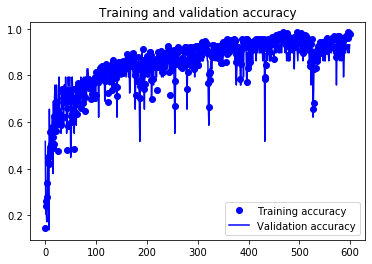

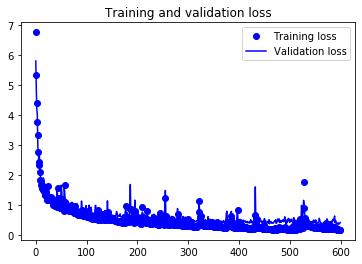

In [24]:
accuracy = model.history.history['acc']
val_accuracy = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**Analysis on viz.** - We have got better graphs where Both training and validation loss go hand in hand. But here because of more number of epochs, the graphs look like they are overfitting by some amount. But we took the decision to go ahead with the model, as most of the test dataset will be normalized between [0,1), and will work better with this model, than the other ones.

# The End


---



